# Amulet Tensorflow training

ติดตั้ง tensorflow

In [2]:
pip install tensorflow numpy matplotlib opencv-python Pillow imghdr

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement imghdr (from versions: none)
ERROR: No matching distribution found for imghdr


นำเข้า tensorflow, numpy และ matplotlib

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import cv2
import PIL
import imghdr



In [4]:
data_dir = pathlib.Path('./models')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

165


In [6]:
labtop = list(data_dir.glob('laptop/*.jpg'))
glass = list(data_dir.glob('glass/*.jpg'))
keyboard = list(data_dir.glob('keyboard/*.jpg'))
monitor = list(data_dir.glob('monitor/*.jpg'))
bottle = list(data_dir.glob('bottle/*.jpg'))

In [7]:
batch_size = 32
img_height = 200
img_width = 200

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 169 files belonging to 5 classes.
Using 136 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 169 files belonging to 5 classes.
Using 33 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['bottle', 'glass', 'keyboard', 'laptop', 'monitor']


In [11]:
def check_images(s_dir, ext_list):
    bad_images = []
    bad_ext = []
    s_list = os.listdir(s_dir)
    for klass in s_list:
        klass_path = os.path.join(s_dir, klass)
        print('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list = os.listdir(klass_path)
            for f in file_list:
                f_path = os.path.join(klass_path, f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                    bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        shape = img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ',
                          f, ' in class directory ', klass)
        else:
            print('*** WARNING*** you have files in ', s_dir,
                  ' it should only contain sub directories')
    return bad_images, bad_ext


good_exts = ['jpg', 'png', 'jpeg', 'gif', 'bmp']
bad_file_list, bad_ext_list = check_images(data_dir, good_exts)
if len(bad_file_list) != 0:
    print('improper image files are listed below')
    for i in range(len(bad_file_list)):
        print(bad_file_list[i])
        # delete bad files
        os.remove(bad_file_list[i])
else:
    print(' no improper image files were found')


processing class directory  bottle
processing class directory  glass
processing class directory  keyboard
processing class directory  laptop
processing class directory  monitor
 no improper image files were found


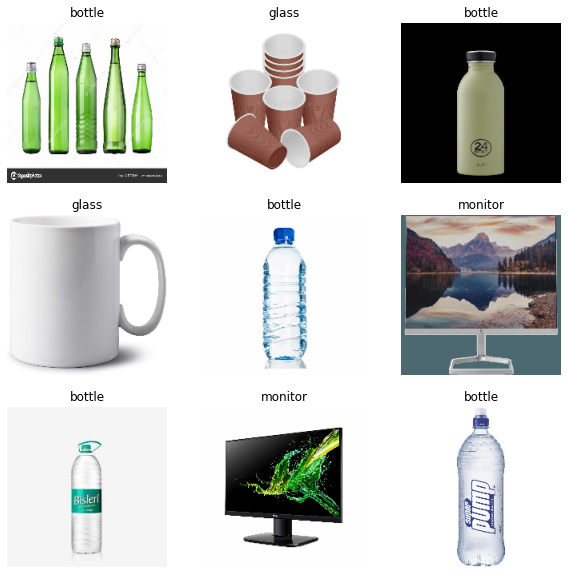

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 200, 200, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0017050949 1.0


In [17]:
num_classes = len(class_names)

layers = tf.keras.layers
Sequential = tf.keras.models.Sequential

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
5/5 [==============================] - 2s 370ms/step - loss: 1.9728 - accuracy: 0.1838 - val_loss: 1.5217 - val_accuracy: 0.2424
Epoch 2/10
5/5 [==============================] - 2s 403ms/step - loss: 1.5808 - accuracy: 0.3235 - val_loss: 1.5216 - val_accuracy: 0.3939
Epoch 3/10
5/5 [==============================] - 2s 344ms/step - loss: 1.4151 - accuracy: 0.5662 - val_loss: 1.5478 - val_accuracy: 0.4545
Epoch 4/10
5/5 [==============================] - 2s 346ms/step - loss: 1.1887 - accuracy: 0.5735 - val_loss: 1.5822 - val_accuracy: 0.3939
Epoch 5/10
5/5 [==============================] - 2s 342ms/step - loss: 0.9486 - accuracy: 0.6618 - val_loss: 1.6773 - val_accuracy: 0.5758
Epoch 6/10
5/5 [==============================] - 2s 365ms/step - loss: 0.5615 - accuracy: 0.8309 - val_loss: 1.6041 - val_accuracy: 0.5152
Epoch 7/10
5/5 [==============================] - 2s 405ms/step - loss: 0.4003 - accuracy: 0.8529 - val_loss: 1.6617 - val_accuracy: 0.6364
Epoch 8/10
5/5 [====

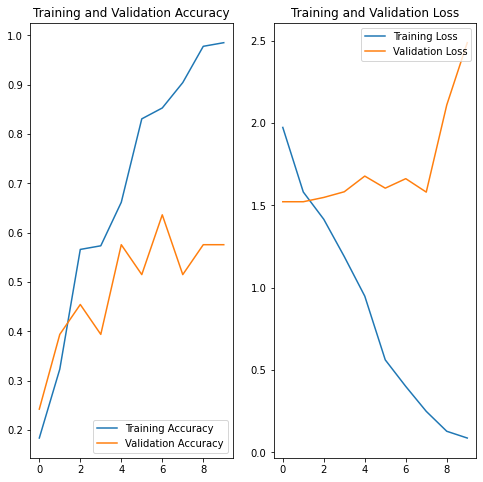

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

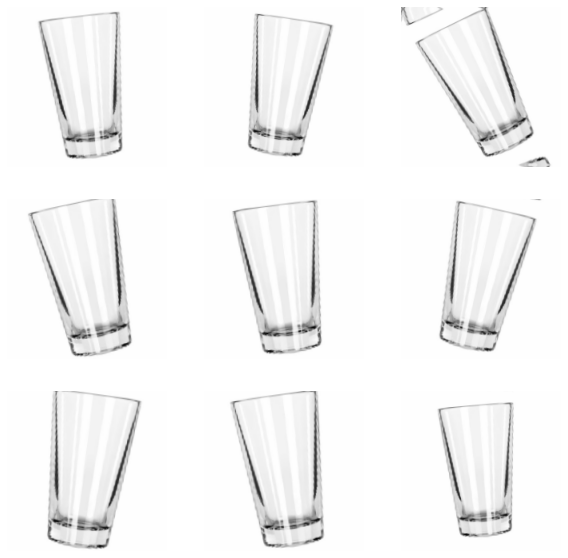

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
5/5 [==============================] - 2s 468ms/step - loss: 2.5469 - accuracy: 0.2500 - val_loss: 1.8328 - val_accuracy: 0.1212
Epoch 2/15
5/5 [==============================] - 2s 372ms/step - loss: 1.5958 - accuracy: 0.3382 - val_loss: 1.5325 - val_accuracy: 0.4242
Epoch 3/15
5/5 [==============================] - 2s 418ms/step - loss: 1.5096 - accuracy: 0.4485 - val_loss: 1.4615 - val_accuracy: 0.4242
Epoch 4/15
5/5 [==============================] - 2s 464ms/step - loss: 1.4060 - accuracy: 0.3529 - val_loss: 1.4638 - val_accuracy: 0.4242
Epoch 5/15
5/5 [==============================] - 2s 461ms/step - loss: 1.3863 - accuracy: 0.3750 - val_loss: 1.4498 - val_accuracy: 0.4242
Epoch 6/15
5/5 [==============================] - 2s 477ms/step - loss: 1.3014 - accuracy: 0.5074 - val_loss: 1.4477 - val_accuracy: 0.4242
Epoch 7/15
5/5 [==============================] - 2s 393ms/step - loss: 1.2269 - accuracy: 0.4706 - val_loss: 1.3988 - val_accuracy: 0.4545
Epoch 8/15
5/5 [====

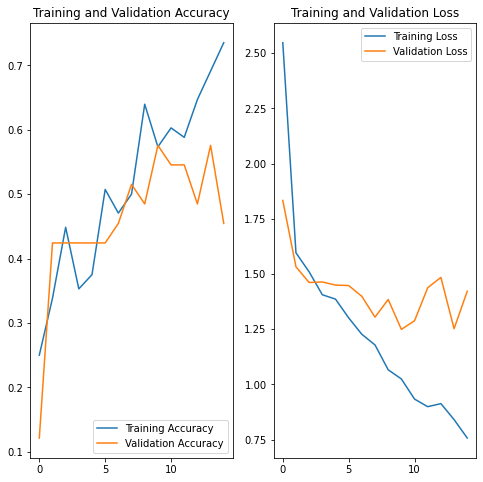

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
img = tf.keras.utils.load_img('./test/check2.jpg', target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to laptop with a 78.33 percent confidence.


In [38]:
# Export model to file
export_path = "./saved_model/"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(export_path + 'model.tflite', 'wb') as f:
    f.write(tflite_model)

# print success message
print("Successfully exported model to: {}".format(export_path))


Successfully exported model to: ./saved_model/
